EE 679 Speech Processing
<br>Computing Assignment 1
<br>Name: Kanak Yadav
<br>Roll No.: 20D070044

In [49]:
# importing modules
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
%matplotlib inline

from scipy.io.wavfile import write

# defining constants
PI = np.pi
Fs = 16000

#### Q1

The relation between resonance frequency/bandwidth, and the pole angle/radius is:
$$
r = e^{-\pi B_1/F_s},
$$
$$
\theta = 2\pi F_1/F_s
$$

The transfer funciton H(z) of a system with two poles is given by:
$$
    H(z) = \dfrac{1}{(1 - z_{p1}z^{-1})(1 - z_{p2}z^{-1})}
$$
In our case the poles $z_{p1}$ and $z_{p2}$ are:
$$
    z_{p1} = re^{j\theta}, z_{p2} = re^{-j\theta}
$$
Thus, after substituting the values and simplification we get the transfer function to be:
$$
    H(z) = \dfrac{1}{1 - 2r\cos{\theta}z^{-1} + r^2z^{-2}}
$$
$$
    = \dfrac{1}{1 - 1.804125z^{-1} + 0.924465z^{-2}}
$$
To find the magnitude response we substitute $ z = e^{j\omega} $ and sweep $\omega$ from 0 to $\pi$.
After simplification, we obtain:
$$
|H(e^{j\omega})| = \dfrac{1}{\sqrt{ (1-r^2)^2 + 4r(\cos\omega - r\cos\theta)(r\cos\omega - \cos\theta) }}
$$

In [50]:
# function to return the r and theta values corresponding to the pole locations given a single resonant frequency and bandwidth pair
def poles_loc(f, b):

    return np.exp(-PI * b / Fs), 2 * PI * f / Fs

# function to plot the magnitude of the transfer function of the two pole resonator characterized by resonant frequency and bandwidth
def plot_mag_single_formant(f, b, plot=True, verify=False):
    
    r, theta = poles_loc(f, b)
    c = np.cos(theta)
    
    omega = np.linspace(0, PI, 1000)
    cos = np.cos(omega)
    
    mag = 4*r * (cos - r*c) * (r*cos - c)
    mag += (1-r**2)**2
    mag = 1/np.sqrt(mag)
    mag = 20 * np.log10(mag)
    
    if plot:
        plt.plot(omega/PI/2*Fs, mag)
        plt.title("Magnitude Response")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("20 log(H(z)) (dB)")

    if verify:
        plt.plot([f]*2, [mag.min(), mag.max()], "r--")
        plt.plot([f-(b/2), f+(b/2)], [mag.max()-3]*2, "g-")

    plt.show()    

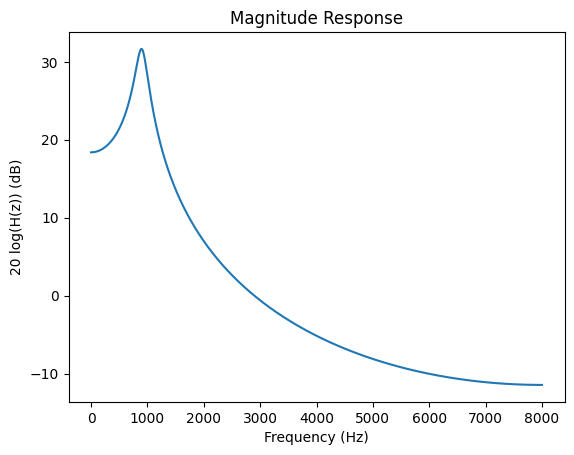

In [51]:
# plotting the magnitude response for frequency and bandwidth given in the question
F1, B1 = 900, 200
plot_mag_single_formant(F1, B1)

We can verify that the peak and the 3db bandwidth are as required by plotting them in the same plot

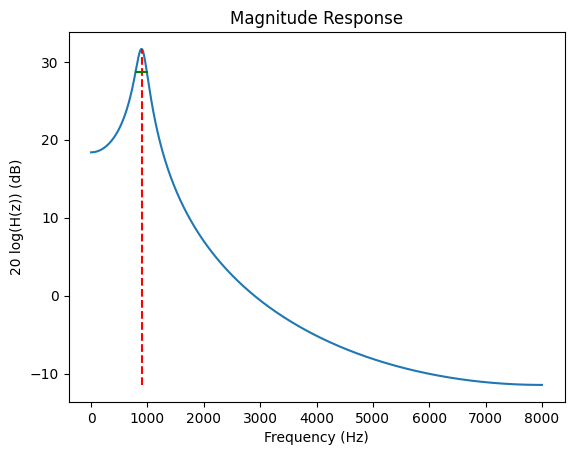

In [52]:
F1, B1 = 900, 200
plot_mag_single_formant(F1, B1, verify=True)

We can see that we get the peak at exactly F1 = 900 Hz and the 3dB bandwidth is also correct.

The transfer function H(z) describes an IIR filter hence to plot the impulse response, we need to use the difference equation implementation of H(z).
$$
    H(z) = \dfrac{Y(z)}{X(z)} = \dfrac{1}{1 - 1.804125z^{-1} + 0.924465z^{-2}}
$$
$$
    Y(z) = X(z) + 1.804125.Y(z)z^{-1} - 0.924465.Y(z)z^{-2}
$$
Taking the inverse z-transform on both sides gives us:
$$
    y[n] = x[n] + 1.804125.y[n-1] - 0.924465.y[n-2]
$$
For our case, we can take y[-1] and y[-2] to be 0 and by taking x[n] to be $\delta[n]$ we can plot the impulse response of the system.

In [53]:
# function to generate the coefficients of z^{-i} for a factor that combines the complementary poles to have real coefficients
def factor(r, theta):

    return np.array([1, -2*r*np.cos(theta), r**2])

# function to generate the coefficients of the denominator of the transfer function after multiplying all the factors
# the coefficients can be found by convolving the coefficients of the factors
def tf_den(f, b):

    a = np.array([1])
    for i in range(len(f)):
        a = np.convolve(a, factor(*poles_loc(f[i], b)))
    
    return a

# function that plots the impulse response of the transfer function using the difference equation implementation
# the output is generated by multiplying the previous outputs by the respective coefficients of the denominator
# this is done via taking the dot product of two vectors
def impulse_response(f, b, len=250, plot=True):
    
    a = tf_den(f, b)[1:]
    a = -a[::-1]
    la = a.shape[0]

    h = np.zeros((len+la,))
    h[la] = 1

    for i in range(1, len):
        h[i+la] = np.dot(h[i:i+la], a)
    
    h = h[la:]
    
    if plot:
        plt.stem(h)
        plt.title("Impulse Response")
        plt.xlabel("samples (n)")
        plt.ylabel("h[n]", rotation=0)
        plt.show()

    return h

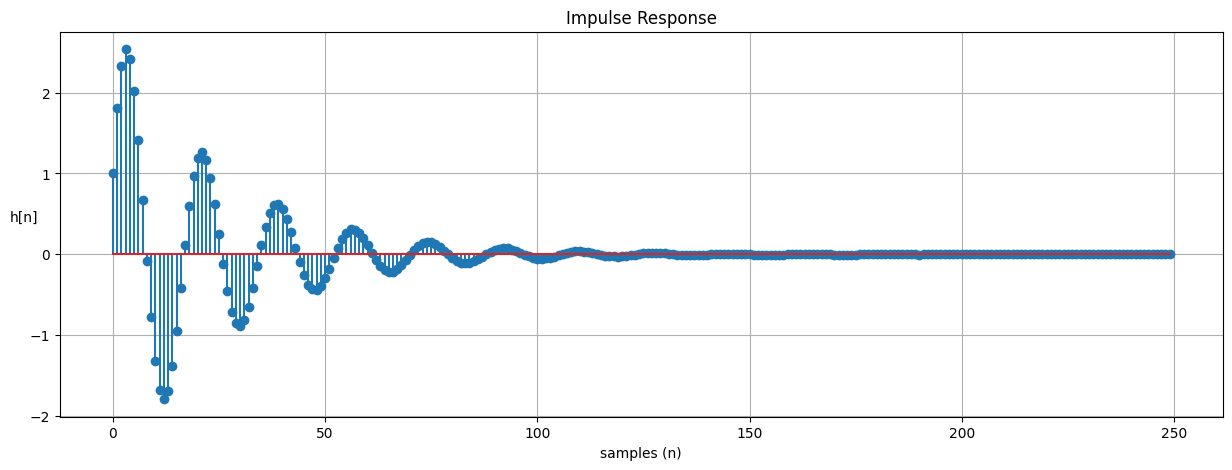

In [54]:
# plotting the impulse response for the system described in the question
plt.figure(figsize=(15, 5))
plt.grid()
h = impulse_response([F1], B1)

The impulse response is as expected: a decaying sinusoid of frequence F1 and decay factor an exponential of the bandwidth.

#### Q2

To excite the filter with a periodic waveform instead of an impulse, we can use the same implemnetation as earlier by just taking x[n] to the required periodic waveform.

One period of the narrow triangular pulse train of the required frequency is generated and given to another function to compute the filter response.

The width of the triangular pulse is proportional to the number of samples per period of the pulse train (1% of the total number of samples).

The number of samples required to generate 0.5 sec duration audio are: sampling rate * time = 16000 * 0.5 = 8000

In [55]:
# function to compute the filter response where x is a periodic waveform
def filter_response(f, b, x=np.array([1]), len=250, plot=True):
    
    a = tf_den(f, b)[1:]
    a = -a[::-1]
    la = a.shape[0]
    lx = x.shape[0]

    y = np.zeros((len+la,))
    
    for i in range(len):
        y[i+la] = np.dot(y[i:i+la], a) + x[i%lx]
    
    y = y[la:]
    
    if plot:
        plt.stem(y)
        plt.title("System Response")
        plt.xlabel("samples (n)")
        plt.ylabel("y[n]", rotation=0)
        plt.show()
    
    return y

# function to generate the triangular pulse train
def triangle(freq, frac=0.01):
    
    x = np.zeros((Fs//freq,))
    len = int(frac * Fs / freq)
    
    if len//2 == 1:
        for i in range(len//2+1):
            x[i] = x[len-i] = 2*i/len
        x[len//2 + 1] = 1
    else:
        for i in range(len//2+1):
            x[i] = x[len-i] = 2*i/len
    
    return x

# function to excite the filter, plot the waveform and generate a 0.5 sec duration audio
def excite_filter(F0, F1, B1, frac=0.1, t=0.5, plot=True, save=""):
    
    x = triangle(F0, frac=frac)
    audio = filter_response(F1, B1, x=x, len=int(Fs*t), plot=False)

    if plot:
        plt.plot(np.linspace(0, 100, Fs//10), audio[:Fs//10])
        plt.title("Audio Waveform")
        plt.xlabel("time (ms)")
        plt.ylabel("s(t)", rotation=0)
    
    if save != "":
        write(f"{save}.wav", Fs, audio)
    return ipd.Audio(audio, rate=Fs)

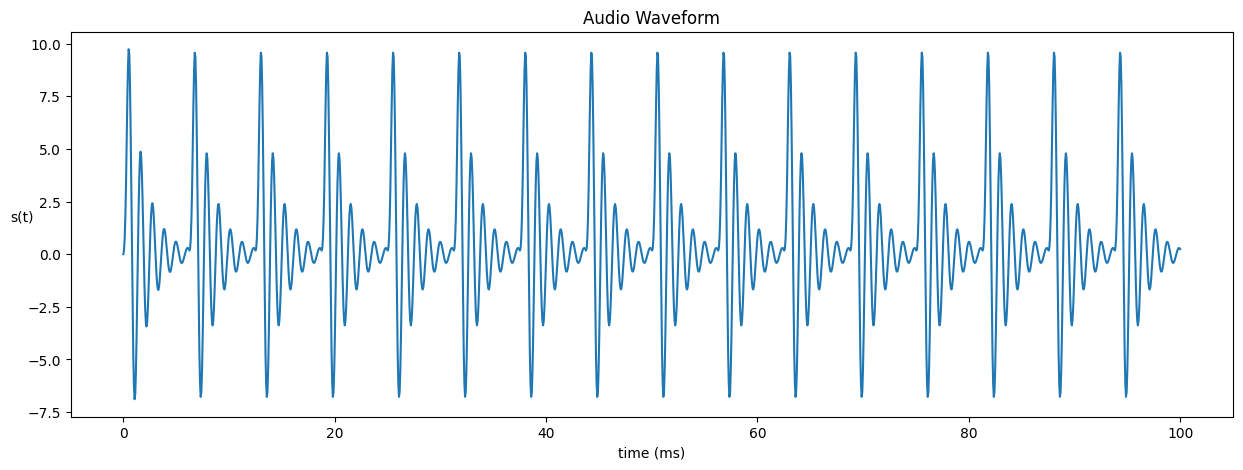

In [56]:
# plotting the waveform and generating the 0.5 sec duration audio
F0 = 160
plt.figure(figsize=(15, 5))
excite_filter(F0, [F1], B1)

The sound feels very monotonous and the vowel/phoneme cannot be identified. It seems to be a nasal sound because we can hear the /n/ spread across the sound.

#### Q3

Since we have already defined the necessary utility functions, we only need to vary the parameters for this question

F0 = 120Hz	F1 = 300Hz	B1 = 120Hz


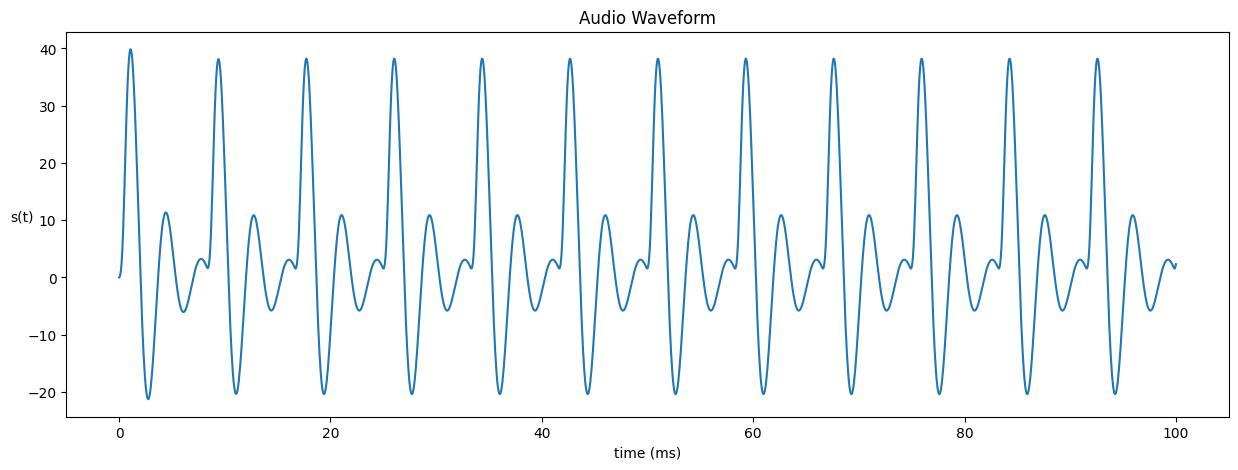

In [57]:
F0, F1, B1 = 120, 300, 120
print(f"F0 = {F0}Hz\tF1 = {F1}Hz\tB1 = {B1}Hz")
plt.figure(figsize=(15, 5))
excite_filter(F0, [F1], B1)

The sound is deep and seems to be saying "ooo" with their nose blocked.

F0 = 120Hz	F1 = 1100Hz	B1 = 200Hz


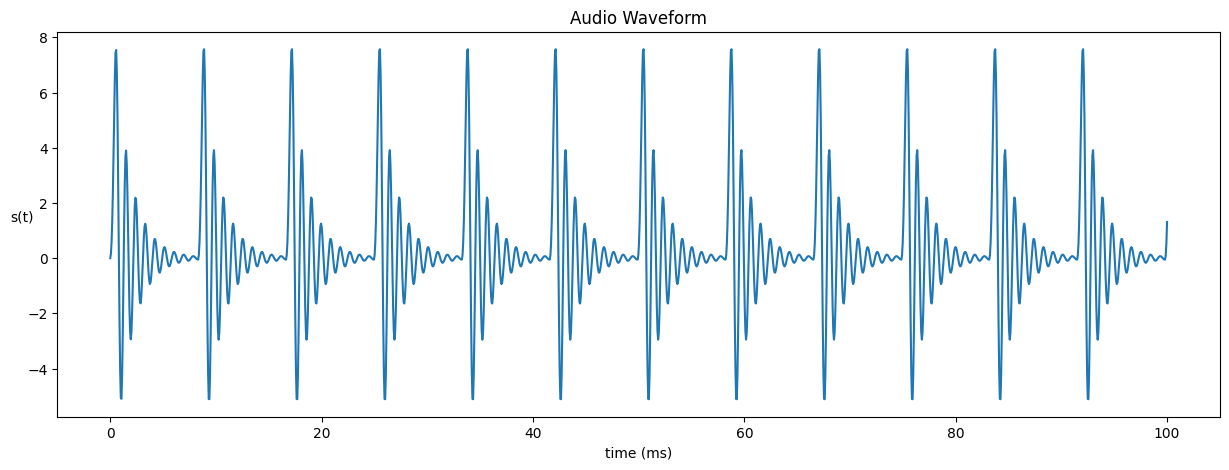

In [58]:
F0, F1, B1 = 120, 1100, 200
print(f"F0 = {F0}Hz\tF1 = {F1}Hz\tB1 = {B1}Hz")
plt.figure(figsize=(15, 5))
excite_filter(F0, [F1], B1)

Again a deep sound but the phoneme has changed and seems to be "aaah".

F0 = 180Hz	F1 = 300Hz	B1 = 120Hz


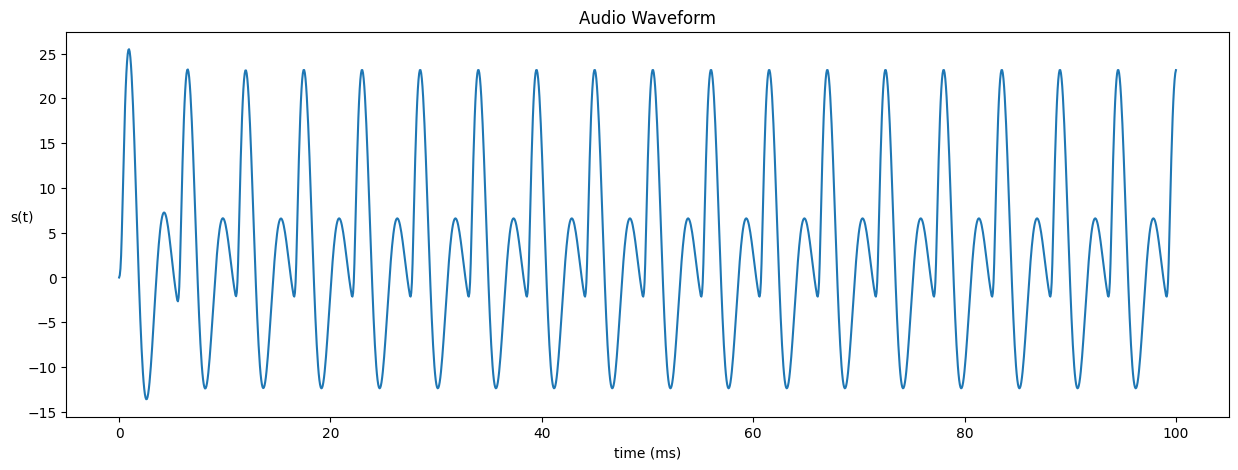

In [59]:
F0, F1, B1 = 180, 300, 120
print(f"F0 = {F0}Hz\tF1 = {F1}Hz\tB1 = {B1}Hz")
plt.figure(figsize=(15, 5))
excite_filter(F0, [F1], B1)

This doesn't sound like something a human would say but rather like a low frequency beep sound.

#### Q4

Again, we just need to vary the parameters for this question.

In [60]:
B = 100
F0 = [120, 220]

In [61]:
F1 = [730, 1090, 2440]

/a/ with F0 = 120Hz


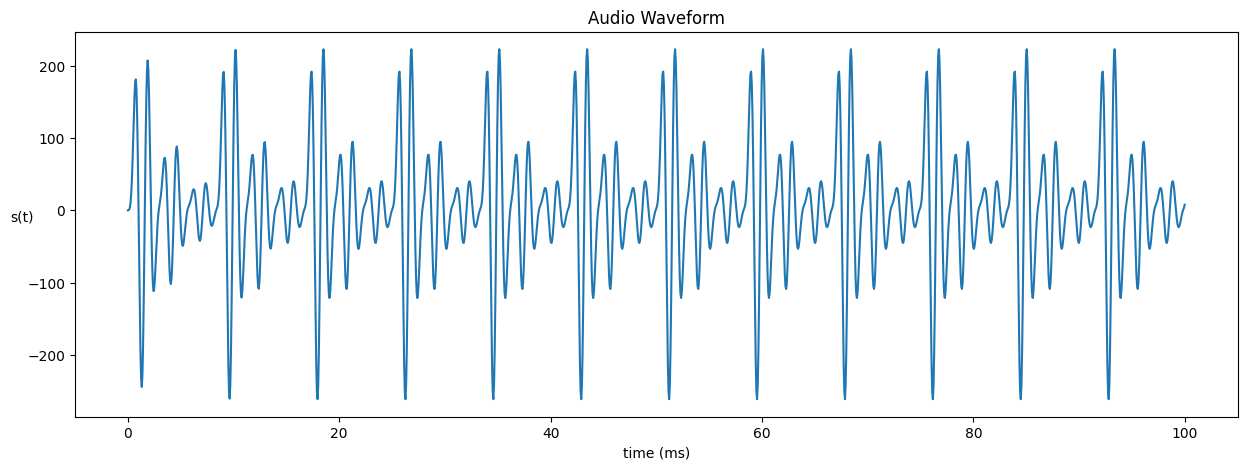

In [62]:
print(f"/a/ with F0 = {F0[0]}Hz")
plt.figure(figsize=(15, 5))
excite_filter(F0[0], F1, B)

Deep sounding /a/ that someone would say with their mouth open wide. There also seems to be a buzzing kind of effect embedded in the sound.

/a/ with F0 = 220Hz


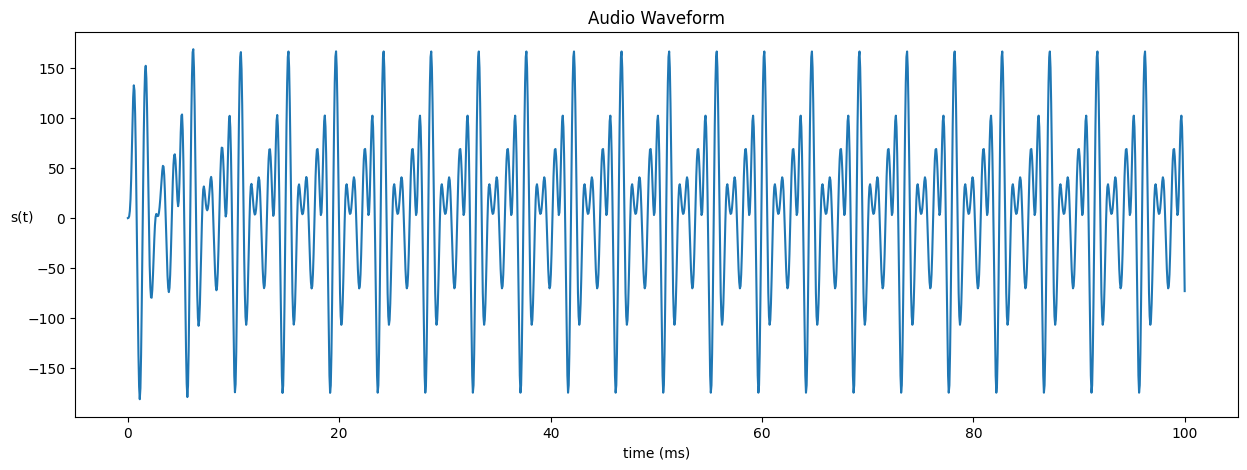

In [63]:
print(f"/a/ with F0 = {F0[1]}Hz")
plt.figure(figsize=(15, 5))
excite_filter(F0[1], F1, B)

Sounds unnaturally high pitched. Although this sound seems to be cleare than the low frequency /a/ sound.

In [64]:
F1 = [270, 2290, 3010]

/i/ with F0 = 120Hz


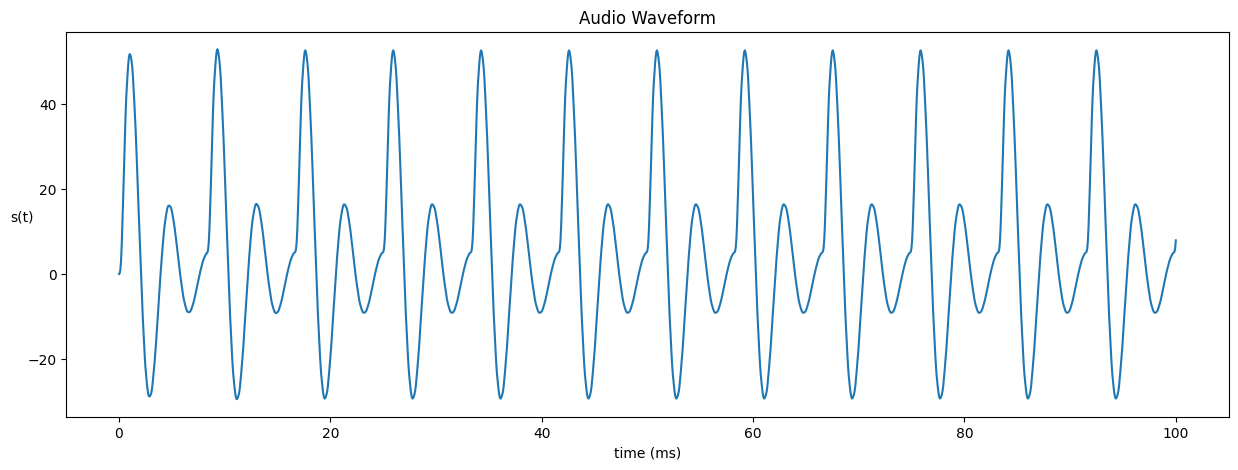

In [65]:
print(f"/i/ with F0 = {F0[0]}Hz")
plt.figure(figsize=(15, 5))
excite_filter(F0[0], F1, B)

The sound cannot be identified as /i/ and sounds like a completely different sound.

/i/ with F0 = 220Hz


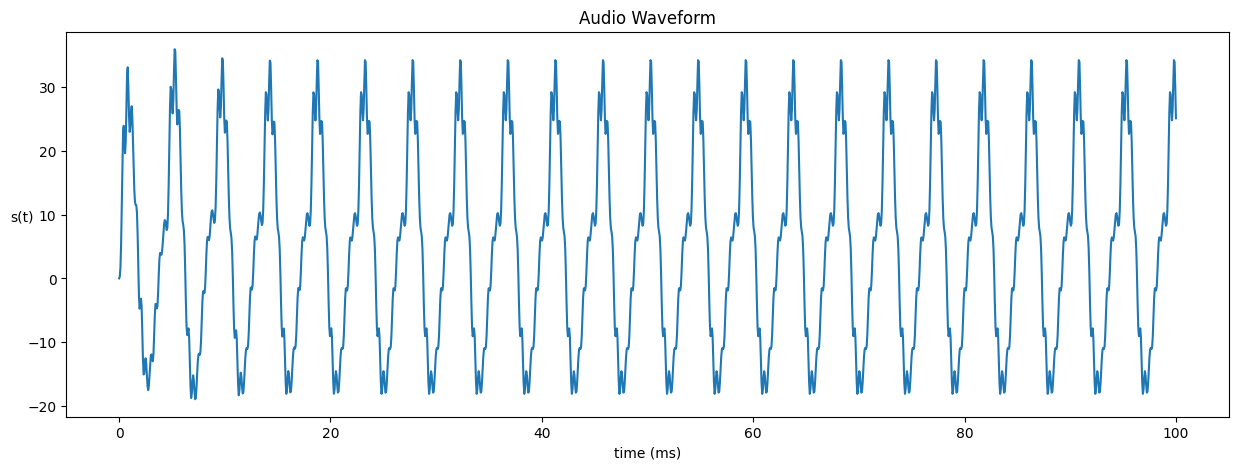

In [66]:
print(f"/i/ with F0 = {F0[1]}Hz")
plt.figure(figsize=(15, 5))
excite_filter(F0[1], F1, B)

This sounds a lot like the spoken /i/ sound. This would mean that this sound is easy to model with very few parameters.

In [67]:
F1 = [300, 870, 2240]

/u/ with F0 = 120Hz


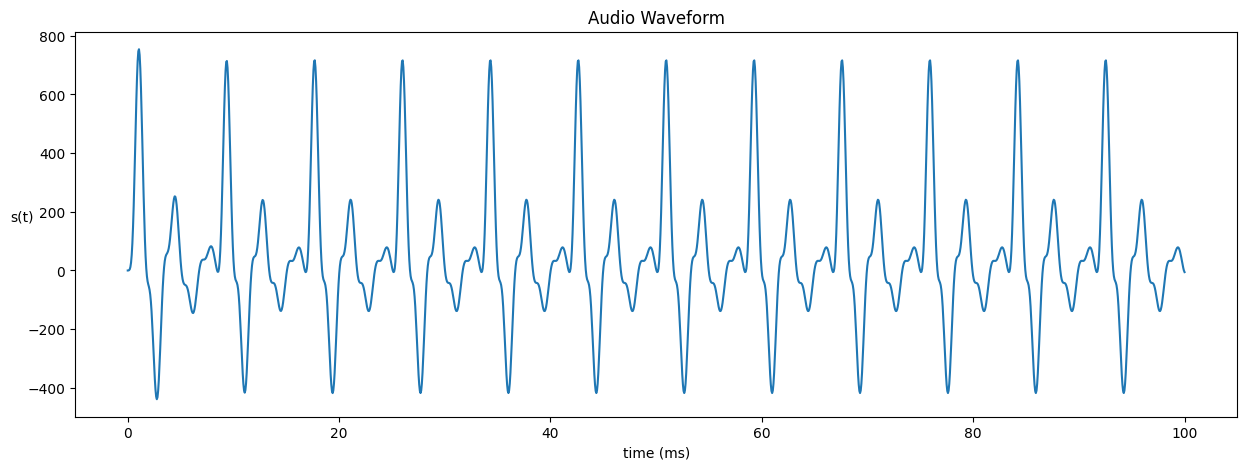

In [68]:
print(f"/u/ with F0 = {F0[0]}Hz")
plt.figure(figsize=(15, 5))
excite_filter(F0[0], F1, B, save="u-120")

Deep /u/ also sounds natural just like the previous sound.

/u/ with F0 = 220Hz


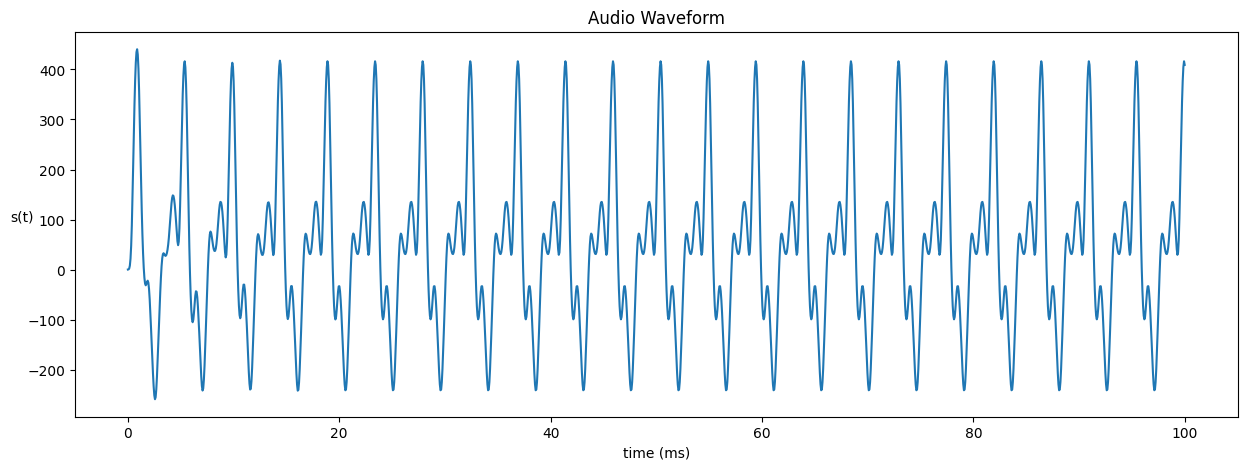

In [69]:
print(f"/u/ with F0 = {F0[1]}Hz")
plt.figure(figsize=(15, 5))
excite_filter(F0[1], F1, B, save="u-220")

Due to the high F0 this /u/ sounds like the /u/ someome would say while shouting instead of speaking in a normal volume.